<KeysViewHDF5 ['density', 'grid', 'pressure', 'time', 'x_velocity', 'y_velocity']>


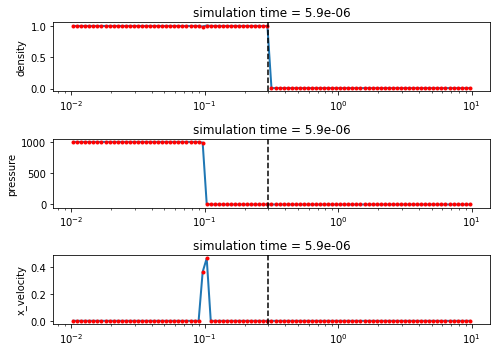

In [2]:
import numpy as np
import h5py
import pylab
import matplotlib.pyplot as plt

edge = 0.3

pylab.figure(figsize=(7,5))
with h5py.File('output/snapshot_0.h5', 'r') as f:
    print(f.keys())
    for n, field in enumerate(['density', 'pressure', 'x_velocity']):
        pylab.subplot(3,1,n+1)
        pylab.semilogx(np.array(f['grid']),
                       np.array(f[field]), 
                       linewidth=2)
        pylab.semilogx(np.array(f['grid']),
                       np.array(f[field]), 
                       ".r",
                       linewidth=2)
        pylab.axvline(edge, color='black', linestyle='--')
        pylab.ylabel(field)
        pylab.title("simulation time = {:.3}".format(f['time'][0])) 
        


pylab.tight_layout()
pylab.show()

In [2]:
N = 100 # number of snapshots

pylab.figure(figsize=(7,5))
i = 0
while i < N:
    with h5py.File('output/snapshot_{}.h5'.format(i), 'r') as f:
        for n, field in enumerate(['density', 'pressure', 'x_velocity']):
            pylab.subplot(3,1,n+1)
            pylab.semilogx(np.array(f['grid']),
                           np.array(f[field]), 
                           "o-",
                           linewidth=2)
            pylab.axvline(edge, color='black', linestyle='--')
            pylab.title("simulation time = {:.3}".format(f['time'][0]))
            
            pylab.ylabel(field)  
            pylab.tight_layout()
            
    # plt.savefig("ss{}.png".format(i))
    plt.clf()
    if i < 5:
        i += 1
    elif i < 30:
        i += 5
    else:
        i += 10
    


# for i in range(0,N,5):
#     with h5py.File('output/snapshot_{}.h5'.format(i), 'r') as f:
#         for n, field in enumerate(['density', 'pressure', 'x_velocity']):
#             pylab.subplot(3,1,n+1)
#             pylab.semilogx(np.array(f['grid']),
#                            np.array(f[field]), 
#                            "o-",
#                            linewidth=2)
#             pylab.axvline(edge, color='black', linestyle='--')
#             pylab.title("simulation time = {:.3}".format(f['time'][0]))
#             pylab.ylabel(field)

    
#     pylab.tight_layout()
#     pylab.show()

<Figure size 504x360 with 0 Axes>

In [11]:
from scipy.signal import find_peaks 
from scipy.optimize import curve_fit

def parabola(x, a, h, k):
    return a*(x-h)**2+k

# shock trajectory
def get_shock_traj(N):
    # N = number of snapshots
    shock_front = np.zeros(N)
    time = np.zeros(N)
    for i in range(N):
        with h5py.File('output/snapshot_%i.h5' % i, 'r') as f:
            P = np.array(f['pressure'])
            rho = np.array(f['density'])
            x_vel = np.array(f['x_velocity'])
            r = np.array(f['grid'])
            peak = find_peaks(x_vel)[0][-1] # the index of the peak
            para_x = r[peak-3:peak+3] # fit a parabola around the peak
            para_y = x_vel[peak-3:peak+3]
            try:
                fit_params, pcov = curve_fit(parabola, para_x, para_y, p0=[-50, r[peak], x_vel[peak]])
                xs = np.linspace(min(para_x), max(para_x), 50)
                shock_front[i] = fit_params[1]
            except RuntimeError:    
                shock_front[i] = r[find_peaks(x_vel)[0][-1]]
            time[i] = np.array(f['time'])[0]
    return time, shock_front

def get_shock_pos(i):
    with h5py.File('output/snapshot_%i.h5' % i, 'r') as f:
            P = np.array(f['pressure'])
            rho = np.array(f['density'])
            x_vel = np.array(f['x_velocity'])
            r = np.array(f['grid'])
            peak = find_peaks(x_vel)[0][-1] # the index of the peak
            para_x = r[peak-3:peak+3] # fit a parabola around the peak
            para_y = x_vel[peak-3:peak+3]
            try:
                fit_params, pcov = curve_fit(parabola, para_x, para_y, p0=[-50, r[peak], x_vel[peak]])
                xs = np.linspace(min(para_x), max(para_x), 50)
                shock_front = fit_params[1]
            except RuntimeError:    
                shock_front[i] = r[find_peaks(x_vel)[0][-1]]
            time = np.array(f['time'])[0]
    return time, shock_front

time, shock_front = get_shock_traj(100)


In [12]:
def trajectory(t, a, b):
    return a*t**b
cut = 13
traj_params, traj_pcov = curve_fit(trajectory, time[cut:], shock_front[cut:], p0=[1., 0.4])
print(traj_params)

[2.57223034 0.47530289]


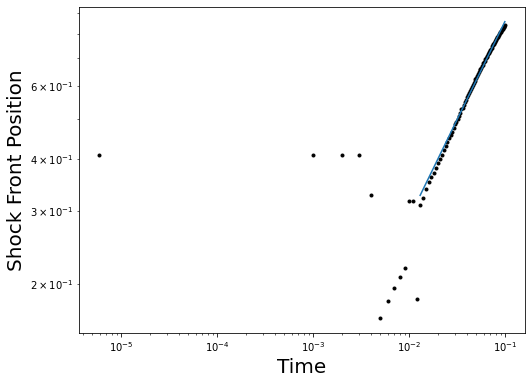

In [13]:
# plot the trajectory
ts = np.linspace(min(time[cut:]), max(time), 100)
plt.figure(figsize=(8,6))
plt.plot(time, shock_front, 'k.')
plt.plot(ts, trajectory(ts, traj_params[0], traj_params[1]))
plt.xlabel('Time', fontsize=20)
plt.ylabel('Shock Front Position', fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.savefig('Shock_Trajectory.pdf')
plt.show()

<IPython.core.display.Javascript object>


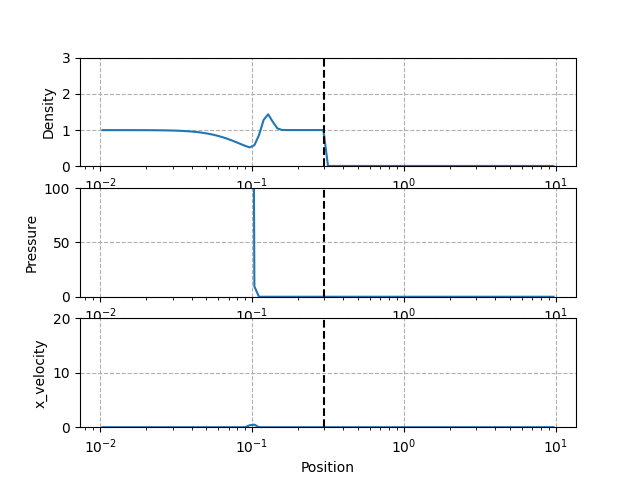

[33 49]
[1.81162461e+01 2.75548465e-15] [1.86141792e+01 2.56972679e-13] [1.75018479e+01 2.39655672e-13]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [14]:
import matplotlib.animation as animation

# animate the shock front
%matplotlib notebook

N = 100 # number of snapshots
shock_front2 = np.zeros(N)
time = np.zeros(N)

with h5py.File('output/snapshot_0.h5', 'r') as f:
    r = np.array(f['grid'])
    rho = np.array(f['density'])
    P = np.array(f['pressure'])
    x_vel = np.array(f['x_velocity'])
    

# initialize
plt.ion()
fig, ax = plt.subplots(3, 1)
x1, = ax[0].plot(r, rho)
x2, = ax[1].plot(r, P)
x3, = ax[2].plot(r, x_vel)

#x4, = ax[3].plot(shock_front, time, 'ko')

ax[0].set_ylabel('Density')
ax[0].set_ylim([0,3])
ax[0].set_xscale('log')
ax[0].axvline(edge, color='black', linestyle='--')
ax[0].grid(ls='--')

ax[1].set_ylabel('Pressure')
ax[1].set_ylim([0,100])
ax[1].set_xscale('log')
ax[1].axvline(edge, color='black', linestyle='--')
ax[1].grid(ls='--')

ax[2].set_ylabel('x_velocity')
ax[2].set_xlabel('Position')
ax[2].set_ylim([0,20])
ax[2].set_xscale('log')
ax[2].axvline(edge, color='black', linestyle='--')
ax[2].grid(ls='--')
#plt.savefig("ss0.png")
# ax[3].set_ylabel('time')
# ax[3].set_xlabel('Shock Front')
# ax[3].set_ylim([0,0.1])
# ax[3].set_xlim([0.01, 100])
# ax[3].set_xscale('log')
# ax[3].grid(ls='--')

fig.canvas.draw()

figs = []


#update
for i in range(1,N):
    with h5py.File('output/snapshot_{:}.h5'.format(i), 'r') as f:
        P = np.array(f['pressure'])
        rho = np.array(f['density'])
        x_vel = np.array(f['x_velocity'])
        r = np.array(f['grid'])
        shock_front2[i] = r[find_peaks(x_vel)[0][-1]]
    ind = get_shock_ind(i)
    x1.set_ydata(rho)
    ax[0].axvline(r[ind], color='r', linestyle='--')
    #ax[0].axvline(shock_front[i], color='black', linestyle='--')
    x2.set_ydata(P)
    ax[1].axvline(r[ind], color='r', linestyle='--')
    #ax[1].axvline(shock_front[i], color='black', linestyle='--')
    x3.set_ydata(x_vel)
    ax[2].axvline(r[ind], color='r', linestyle='--')
    #ax[2].axvline(shock_front[i], color='black', linestyle='--')
    #ax[2].axvline(shock_front2[i], color='red', linestyle='--')
    #x4.set_ydata(shock_front)
    fig.canvas.draw()
    plt.tight_layout()
    plt.pause(0.001)

    


In [4]:
from scipy.signal import find_peaks
from scipy.signal import argrelextrema



#Energy functions
def get_shock_ind(i):
    """Locates the index of the shock front based on the x velocity
    
    Parameters:
        i (int): snapshot number
        
    Returns:
        ind (int): the index of the shock front
    """
    with h5py.File('output/snapshot_%i.h5' % i, 'r') as f:
        x_vel = np.array(f['x_velocity'])
        inds = argrelextrema(x_vel, np.greater_equal)
        for n in inds:
            print(n)
            print(x_vel[n-1], x_vel[n], x_vel[n+1])
        #ind = find_peaks(x_vel)[0][-1] 
        #maxes = np.argmax(x_vel)
    return 
        

def energies(i, g, K=False, T=False, tot=False):
    """Determines the kinetic, thermal and total energy interior to the schock front
    Can choose which of the energies you would like calculated
    - Calculates the kinetic energy with
    T = 1/2 * rho * v^2 * V
    where rho  is density, v is velocity, and V is volume
    - Calculates thermal energy is with 
    E_T = (P*V)/(g - 1)
    where P is pressure, V is volume, and g(gamma) is the adiabatic index
    
    Params:
        i (int): snapshot number
        g (float): adiabatic index -or- specific heat ratio
        K (bool): checks if kinetic energy should be calculated
        T (bool): checks if thermal energy should be calculated
        Tot (bool): checks if total energy should be calculated - K and T must also be True
    
    Returns:
        E_K (float or None): the kinetic energy
        E_T (float or None): the thermal energy
        E_tot (float or None): the total energy
    """
    E_K = None
    E_T = None
    E_tot = None
    with h5py.File('output/snapshot_%i.h5' % i, 'r') as f:
        #ind = get_shock_ind(i)
        rho = np.array(f['density'])#[:ind]
        v_x = np.array(f['x_velocity'])#[:ind]
        P = np.array(f["pressure"])#[:ind]
        r = np.array(f['grid'])#[:ind]
        n_ind = np.where(v_x<0)
        v_x[n_ind] = -v_x[n_ind]
        
    """
    THIS IS WITH SHELL APPROX
    -------------------------
    
    dr = np.zeros(len(r))
    r1 = r[2:]
    r2 = r[:-2]
    dr[1:-1] = (r1 - r2)/2
    dr[0] = (r[1] - r[0])/2 + r[0]
    dr[-1] = (r[-1] - r[-2])/2 
    V_s = 4*np.pi*r**2*dr  # the volume of each shell
    
    """
    """
    THIS IS WITH SPHERE VOLUME DIFFERENCE
    -------------------------------------
    """
    edges = np.zeros(len(r))
    R1 = r[1:]
    R2 = r[:-1]
    edges[:-1] = (R1 + R2)/2
    edges[-1] = r[-1]
    V_s = 4/3*np.pi*edges**3
    V1 = V_s[1:]
    V2 = V_s[:-1]
    V_s[1:] = V1 - V2
    print(V_s)
    
    if K:
        E_Ks = 1/2*rho*v_x**2*V_s  # array of E_K for each shell
        E_K = np.sum(E_Ks)  # total kinetic energy
        
    if T: 
        E_Ts = P*V_s/(g - 1)  # array of E_T for each shell
        E_T = np.sum(E_Ts)  # total thermal energy
    
    if tot:
        try:
            E_tot = E_T + E_K
        except TypeError:
            print("Total energy can only be calculated if both K and T == True")
    
    return E_K, E_T, E_tot

print(energies(10, 5/3, K=False, T=False, tot=False))       



[5.18302354e-06 1.20685013e-06 1.48786125e-06 1.83430489e-06
 2.26141680e-06 2.78798033e-06 3.43715246e-06 4.23748220e-06
 5.22416612e-06 6.44059617e-06 7.94026798e-06 9.78913349e-06
 1.20685013e-05 1.48786125e-05 1.83430489e-05 2.26141680e-05
 2.78798033e-05 3.43715246e-05 4.23748220e-05 5.22416612e-05
 6.44059617e-05 7.94026798e-05 9.78913349e-05 1.20685013e-04
 1.48786125e-04 1.83430489e-04 2.26141680e-04 2.78798033e-04
 3.43715246e-04 4.23748220e-04 5.22416612e-04 6.44059617e-04
 7.94026798e-04 9.78913349e-04 1.20685013e-03 1.48786125e-03
 1.83430489e-03 2.26141680e-03 2.78798033e-03 3.43715246e-03
 4.23748220e-03 5.22416612e-03 6.44059617e-03 7.94026798e-03
 9.78913349e-03 1.20685013e-02 1.48786125e-02 1.83430489e-02
 2.26141680e-02 2.78798033e-02 3.43715246e-02 4.23748220e-02
 5.22416612e-02 6.44059617e-02 7.94026798e-02 9.78913349e-02
 1.20685013e-01 1.48786125e-01 1.83430489e-01 2.26141680e-01
 2.78798033e-01 3.43715246e-01 4.23748220e-01 5.22416612e-01
 6.44059617e-01 7.940267

<IPython.core.display.Javascript object>


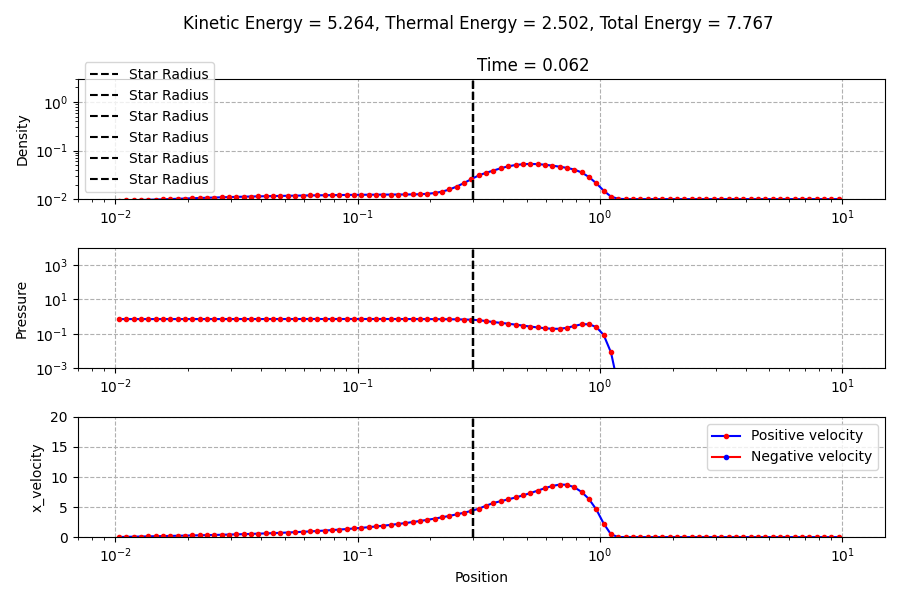

In [16]:
from matplotlib.animation import FuncAnimation
from matplotlib.artist import Artist
import matplotlib.animation as animation

N = 100

fig = plt.figure(figsize=(9,6)) 
gs = fig.add_gridspec(3,1)
ax = gs.subplots()

ln1, = ax[0].plot([], [])
ln1.set_color("b")
ln1.set_marker(".")
ln1.set_mfc("r")
ln1.set_mec("r")

ln2, = ax[1].plot([], [])
ln2.set_color("b")
ln2.set_marker(".")
ln2.set_mfc("r")
ln2.set_mec("r")

ln3, = ax[2].plot([], [], label='Positive velocity')
ln3.set_color("b")
ln3.set_marker(".")
ln3.set_mfc("r")
ln3.set_mec("r")

ln4, = ax[2].plot([], [], label='Negative velocity')
ln4.set_color("r")
ln4.set_marker(".")
ln4.set_mfc("b")
ln4.set_mec("b")


def init():
    ax[0].set_ylabel('Density')
    ax[0].set_ylim([1e-2,3])
    ax[0].set_xlim([7e-3, 1.5e1])
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].axvline(edge, color='black', linestyle='--', label="Star Radius")
    ax[0].grid(ls='--')
    ax[0].legend()
    
    ax[1].set_ylabel('Pressure')
    ax[1].set_ylim([1e-3,1e4])
    ax[1].set_xlim([7e-3, 1.5e1])
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].axvline(edge, color='black', linestyle='--')
    ax[1].grid(ls='--')

    ax[2].set_ylabel('x_velocity')
    ax[2].set_xlabel('Position')
    ax[2].set_ylim([0,20])
    ax[2].set_xlim([7e-3, 1.5e1])
    ax[2].set_xscale('log')
    ax[2].axvline(edge, color='black', linestyle='--')
    ax[2].grid(ls='--')
    ax[2].legend()
    return ln1, ln2, ln3, ln4

def update(i):
    with h5py.File('output/snapshot_%i.h5' % i, 'r') as f:
        P = np.array(f['pressure'])
        rho = np.array(f['density'])
        x_vel = np.array(f['x_velocity'])
        r = np.array(f['grid'])
        p_ind = np.where(x_vel>0)
        n_ind = np.where(x_vel<0) 
        t = f['time'][0]
        #x_vel[n_ind] = -x_vel[n_ind]
    
    E_K, E_T, E_tot = energies(i, 5/3, K=True, T=True, tot= True)
    ax[0].set_title("""Kinetic Energy = {K:.3f}, Thermal Energy = {T:.3f}, Total Energy = {tot:.3f} \n 
                    Time = {time:.3f}""".format(K=E_K, T=E_T, tot=E_tot, time=t))
    
    #ind = get_shock_ind(i)
    
    #ax[2].axvline(r[ind], color='r', linestyle='--')
    
    ln1.set_data(r, rho)  
    ln2.set_data(r, P)
    ln3.set_data(r, x_vel)
    ln4.set_data(r[n_ind], -x_vel[n_ind])
    
    plt.tight_layout()
    return ln1, ln2, ln3, ln4

ani = FuncAnimation(fig, update, frames=np.linspace(0, N, N),
                    init_func=init, blit=True)

mywriter = animation.FFMpegWriter(fps=12) 
ani.save('myanimation.mp4', writer=mywriter)